# Results and Analysis

This notebook can be run to reproduce the results and figures in our paper.

## Imports and Setup

In [17]:
# Imports
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from evaluation import evaluate_dataframe
from helper_functions import check_dir_exists

# Set directories
path = os.getcwd()
main_dir = os.path.split(path)[0]
print(f'The working directory is {main_dir}')
results_dir = f"{main_dir}/results"

The working directory is /Users/hannahrosekirk/Documents/Local_Github/cheap_learning


## Load Json Results Files

In [10]:
# Initialise frames
frames = []

# Loop through task folders
tasks_list = [name for name in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, name))]
print(f'TASK LIST: {tasks_list}')
for task_name in tasks_list:
  print(f'For TASK == {task_name}:')
  task_dir = f'{results_dir}/{task_name}'
  # Loop through techniques folders
  techniques_list = [name for name in os.listdir(task_dir) if os.path.isdir(os.path.join(task_dir, name))]
  print(f'\tTECH LIST: {techniques_list}')
  for technique_name in techniques_list:
    tech_dir = f'{task_dir}/{technique_name}/'
    # Load jsons
    for file_name in [file for file in os.listdir(tech_dir) if file.endswith('.json')]:
      with open(tech_dir+ file_name) as json_file:
        data = json.load(json_file)
        df = pd.DataFrame.from_dict(data, orient='index')
        # Append to frames list
        frames.append(df)

# Create dataframe
results_df = pd.concat(frames, axis = 1).T

# Reset index
results_df.index = pd.RangeIndex(start=0, step=1, stop=len(results_df))

# Evaluate column scores
results_df[['acc', 'f1', 'prec', 'recall']] = results_df.apply(evaluate_dataframe, axis=1, result_type="expand")

# Print number of entries
print(f'There are total {len(results_df)} completed experimental runs.')
# Preview dataframe
results_df.head(3)

TASK LIST: ['binary_abuse']
For TASK == binary_abuse:
	TECH LIST: ['transfer_learning']
There are total 30 completed experimental runs.


,task,technique,model,train_runtime,n_train,n_dev,n_test,balanced_train,datetime,test_true,test_pred,dev_true,dev_pred,seed,acc,f1,prec,recall
0,binary_abuse,transfer_learning,distilbert-base-cased,63.951,100,1000,1000,True,20221128-153106,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, ...",1,0.809,0.681301,0.909651,0.809
1,binary_abuse,transfer_learning,distilbert-base-cased,63.9282,100,1000,1000,False,20221128-141013,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,0.895,0.472296,0.801025,0.895
2,binary_abuse,transfer_learning,distilbert-base-cased,190.3254,1000,1000,1000,True,20221128-154355,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, ...",1,0.900,0.799493,0.938996,0.900


# Plotting

In [22]:
def plot_learning_curves(results_df, results_dir, task, technique, model_name=None):
    """Function for plotting learning curves on one task, technique and model.

    Args:
        results_df (pd.DataFrame): Dataframe with loaded json results.
        task (str): Target task e.g. 'binary_abuse'
        technique (str): Learning technique e.g. 'transfer_learning'
        model_name (str, optional): Name of model. Defaults to None.
    """
    # Set up figure
    fig, ax = plt.subplots(1,1, figsize = (10,10))

    # Subset datasets
    if model_name==None:
        subset_df = results_df[(results_df['task']==task) & (results_df['technique']==technique)]
    else:
        subset_df = results_df[(results_df['task']==task) & (results_df['technique']==technique)&(results_df['model']==model_name)]
    subset_df = subset_df.sort_values(by = 'n_train')

    # Loop through balanced and unbalanced
    for balanced_bool in subset_df['balanced_train'].unique():
        bal_df = subset_df[(subset_df['balanced_train']==balanced_bool)]
        # Calculate means across seeds
        means= bal_df.groupby('n_train').mean(numeric_only=True).reset_index()
        xs = means['n_train']
        ys = means['f1']
        # Calculate stds across seeds
        std= bal_df.groupby('n_train').std(numeric_only=True).reset_index()
        ys_err = std['f1']
        # Plot curves
        ax.plot(xs, ys, label = f'balanced_train={balanced_bool}', marker = 'o', markersize = 5)
        ax.fill_between(xs, ys - ys_err, ys + ys_err, alpha=0.2)
        # Plot model name in corner
        if model_name!=None:
            short_model_name = model_name.split('-')[0]
            ax.text(1, 0, ha = 'right', va = 'bottom', s = short_model_name, fontsize = 18, transform=ax.transAxes, color = 'black')
    # Set axis params
    ax.set_xlabel("Number of training entries", fontsize = 16)
    ax.set_ylabel("Macro-F1 Score", fontsize = 16)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend(fontsize = 16, loc = 'upper left')
    ax.set_title(f'Task={task}, Technique={technique}', fontsize = 18, fontweight = 'semibold')

    # Save figure
    save_dir_pdf = f'{results_dir}/figures/pdf'
    save_dir_png = f'{results_dir}/figures/png'
    if model_name==None:
        save_name = f'{task}_{technique}_learningcurve'
    else:
        save_name = f'{task}_{technique}_{short_model_name}_learningcurve'
    # Save png
    check_dir_exists(save_dir_png)
    fig.savefig(f'{save_dir_png}/{save_name}.png', dpi = 600, format = 'png', bbox_inches = 'tight')
    # Save pdf
    check_dir_exists(save_dir_pdf)
    fig.savefig(f'{save_dir_pdf}/{save_name}.pdf', format = 'pdf', bbox_inches = 'tight')

    # Show plt
    plt.show()
    

Folder exists: /Users/hannahrosekirk/Documents/Local_Github/cheap_learning/results/figures/png
Creating /Users/hannahrosekirk/Documents/Local_Github/cheap_learning/results/figures/pdf folder


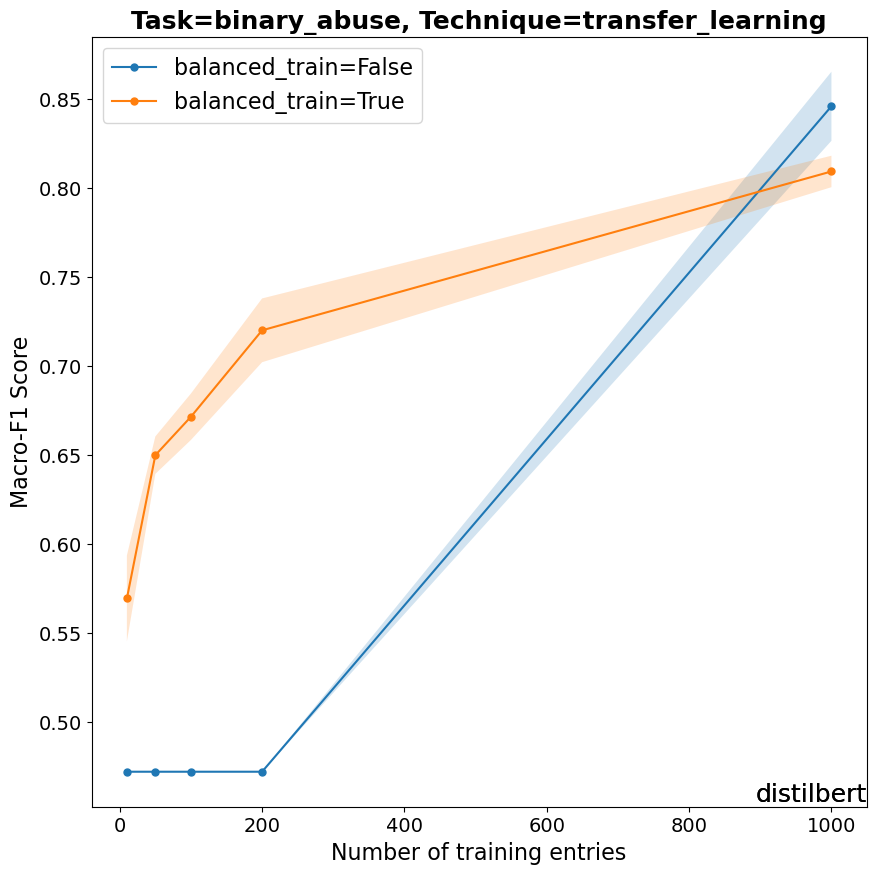

In [23]:
# Example Usage
plot_learning_curves(results_df, results_dir, 'binary_abuse', 'transfer_learning', 'distilbert-base-cased')